# Project 2 - Multiple Myeloma Survival


In [5]:
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

import os

# Set white background for all plots
plt.style.use('default')
sns.set_style("white")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create plots directory
os.makedirs("./plots", exist_ok=True)

In [41]:
df = pd.read_csv('./data/train_data.csv')

In [42]:

def create_submission_file(predictions, filename):
    """
    Create a submission file with predictions.
    
    Args:
        predictions (array-like): The predicted values for SurvivalTime.
        filename (str): The name of the output file.
    """
    # Load the sample submission to get the 'Id' column structure
    sample_submission = pd.read_csv('./data/sample_submission.csv')

    # Ensure that predictions are a single column (reshape if necessary)
    predictions = pd.Series(predictions).values
    
    # Create the submission DataFrame
    submission = pd.DataFrame(columns=sample_submission.columns) 
    submission['id'] = range(len(predictions))
    submission['0'] = predictions # Add the predictions to the 'SurvivalTime' column

    # Save the DataFrame to CSV
    os.makedirs("./results", exist_ok=True)
    submission.to_csv(f'./results/{filename}', index=False)

    print(f"File Created: ./results/{filename}")


In [76]:
def error_metric(y, y_hat, c):
    """
    Censored Mean Squared Error calculation.
    c = 0 for uncensored data points
    c = 1 for censored data points
    
    Args:
        y (array-like): True Survival Time values.
        y_hat (array-like): Predicted Survival Time values.
        c (array-like): Censoring indicators (0 for uncensored, 1 for censored).
        
    Returns:
        float: The Censored Mean Squared Error.
    """
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

## Task 1 - Setting the baseline

### Task 1.1 - Data preparation and validation pipeline


/mnt/c/Users/josep/Ambiente de Trabalho/UNI Mestrado/AA/Projetos/P2/.venv/lib/python3.12/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


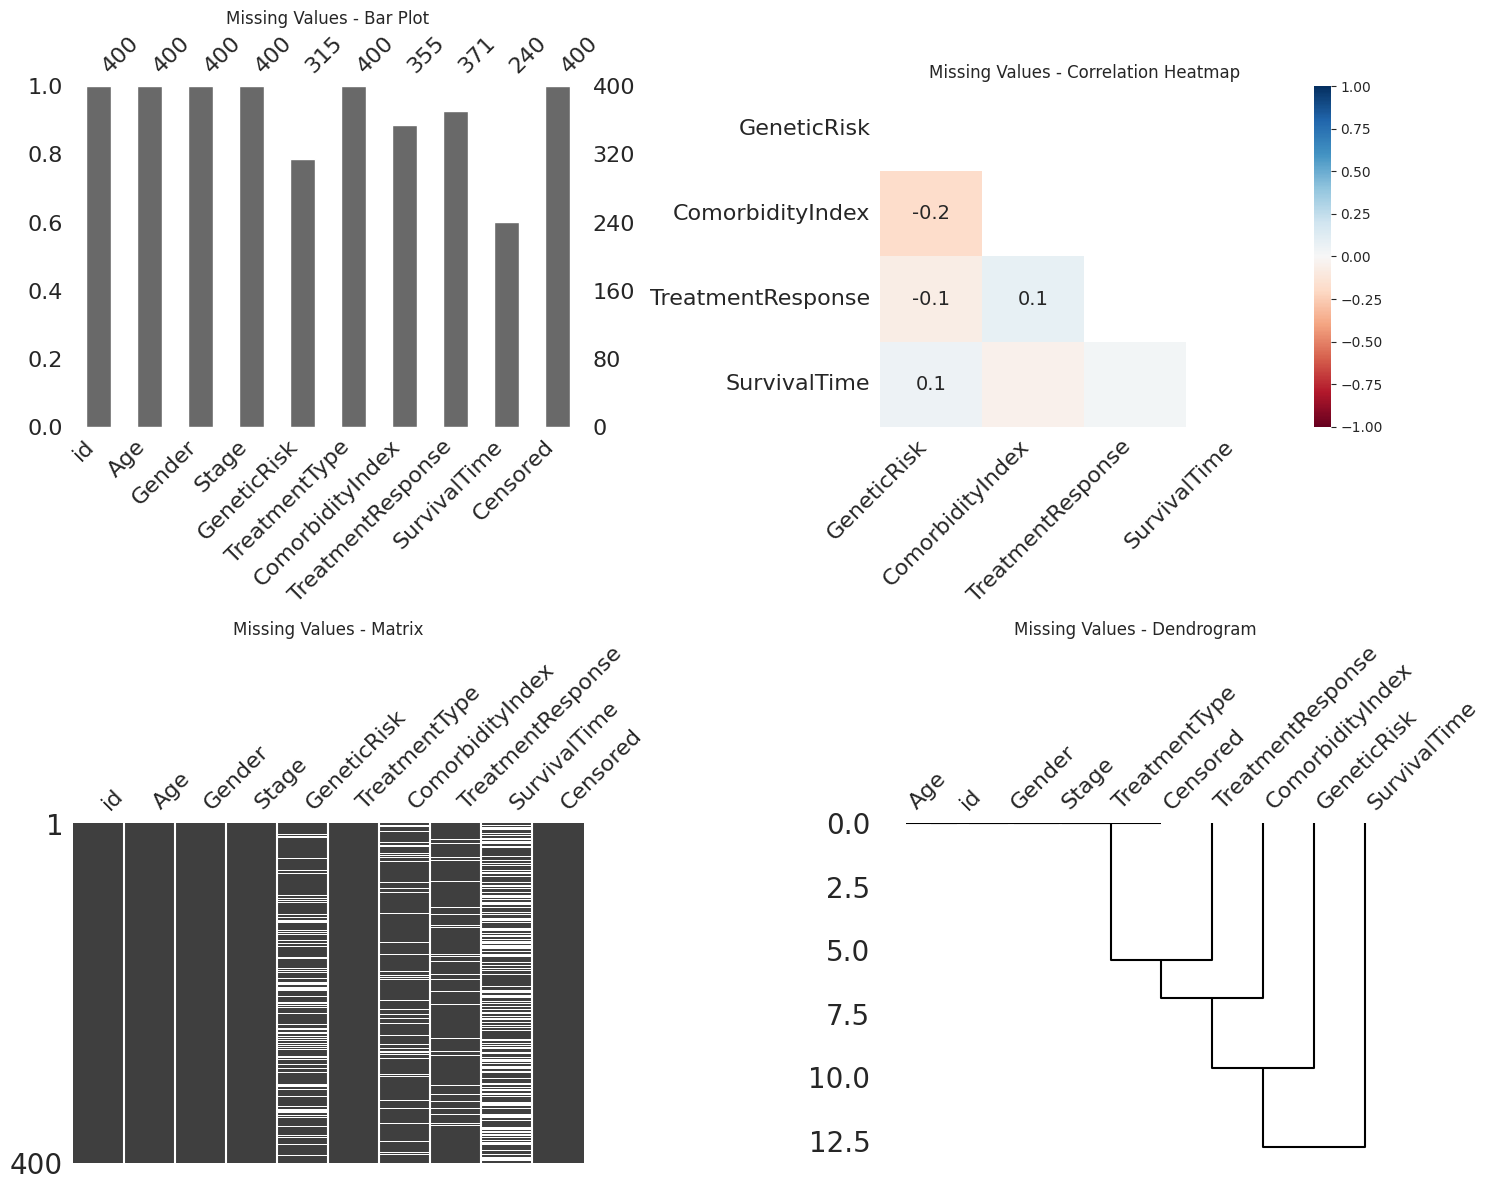

/mnt/c/Users/josep/Ambiente de Trabalho/UNI Mestrado/AA/Projetos/P2/.venv/lib/python3.12/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


In [43]:
# Visualize missing values using multiple missingno plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.patch.set_facecolor('white')

# Bar plot
plt.subplot(2, 2, 1)
msno.bar(df, ax=plt.gca())
plt.title('Missing Values - Bar Plot')

# Heatmap
plt.subplot(2, 2, 2)
msno.heatmap(df, ax=plt.gca())
plt.title('Missing Values - Correlation Heatmap')

# Matrix
plt.subplot(2, 2, 3)
msno.matrix(df, ax=plt.gca())
plt.title('Missing Values - Matrix')

# Dendrogram
plt.subplot(2, 2, 4)
msno.dendrogram(df, ax=plt.gca())
plt.title('Missing Values - Dendrogram')

plt.tight_layout()
plt.savefig('./plots/missing_values_overview.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save each plot separately
fig_bar = plt.figure(figsize=(10, 6))
fig_bar.patch.set_facecolor('white')
msno.bar(df, ax=plt.gca())
plt.title('Missing Values - Bar Plot')
plt.tight_layout()
plt.savefig('./plots/missing_values_bar.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_heatmap = plt.figure(figsize=(10, 6))
fig_heatmap.patch.set_facecolor('white')
msno.heatmap(df, ax=plt.gca())
plt.title('Missing Values - Correlation Heatmap')
plt.tight_layout()
plt.savefig('./plots/missing_values_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_matrix = plt.figure(figsize=(10, 6))
fig_matrix.patch.set_facecolor('white')
msno.matrix(df, ax=plt.gca())
plt.title('Missing Values - Matrix')
plt.tight_layout()
plt.savefig('./plots/missing_values_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_dendrogram = plt.figure(figsize=(10, 6))
fig_dendrogram.patch.set_facecolor('white')
msno.dendrogram(df, ax=plt.gca())
plt.title('Missing Values - Dendrogram')
plt.tight_layout()
plt.savefig('./plots/missing_values_dendrogram.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

Original data points: 400
Remaining data points after cleaning: 161
Data points dropped: 239
Columns retained: ['id', 'Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime', 'Censored']


<Figure size 1000x600 with 0 Axes>

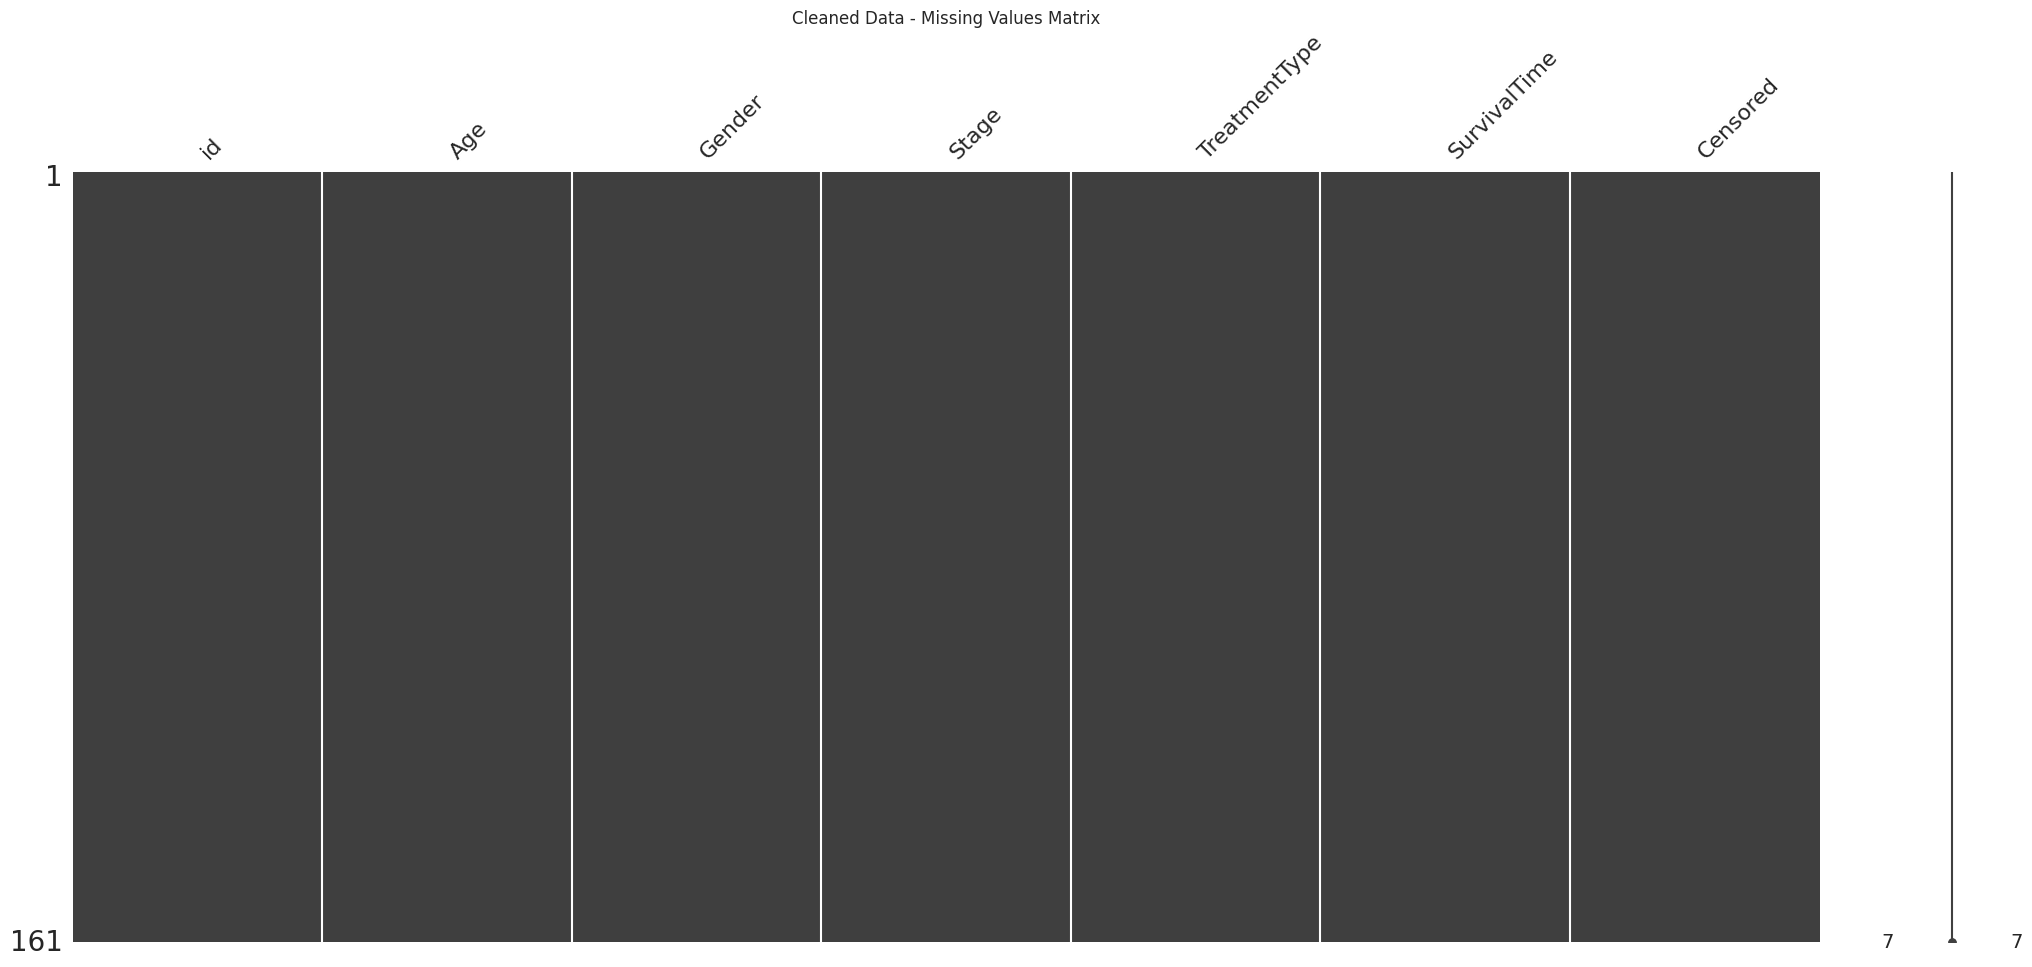

In [78]:
# Data cleaning for baseline model
# 1. Drop rows with missing 'SurvivalTime' values
df_cleaned = df[df['SurvivalTime'].notnull()].copy()

# 2. Drop columns with missing data (baseline approach)
df_cleaned = df_cleaned.dropna(axis=1)

# 3. Drop censored cases (Censored == 1) for baseline
# Censoring occurs when the exact time of an event (death/recurrence) is unknown
df_cleaned = df_cleaned[df_cleaned['Censored'] == 0]

print(f"Original data points: {df.shape[0]}")
print(f"Remaining data points after cleaning: {df_cleaned.shape[0]}")
print(f"Data points dropped: {df.shape[0] - df_cleaned.shape[0]}")
print(f"Columns retained: {list(df_cleaned.columns)}")

# Visualize cleaned data
fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('white')
msno.matrix(df_cleaned)
plt.title('Cleaned Data - Missing Values Matrix')
plt.savefig('./plots/cleaned_data_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

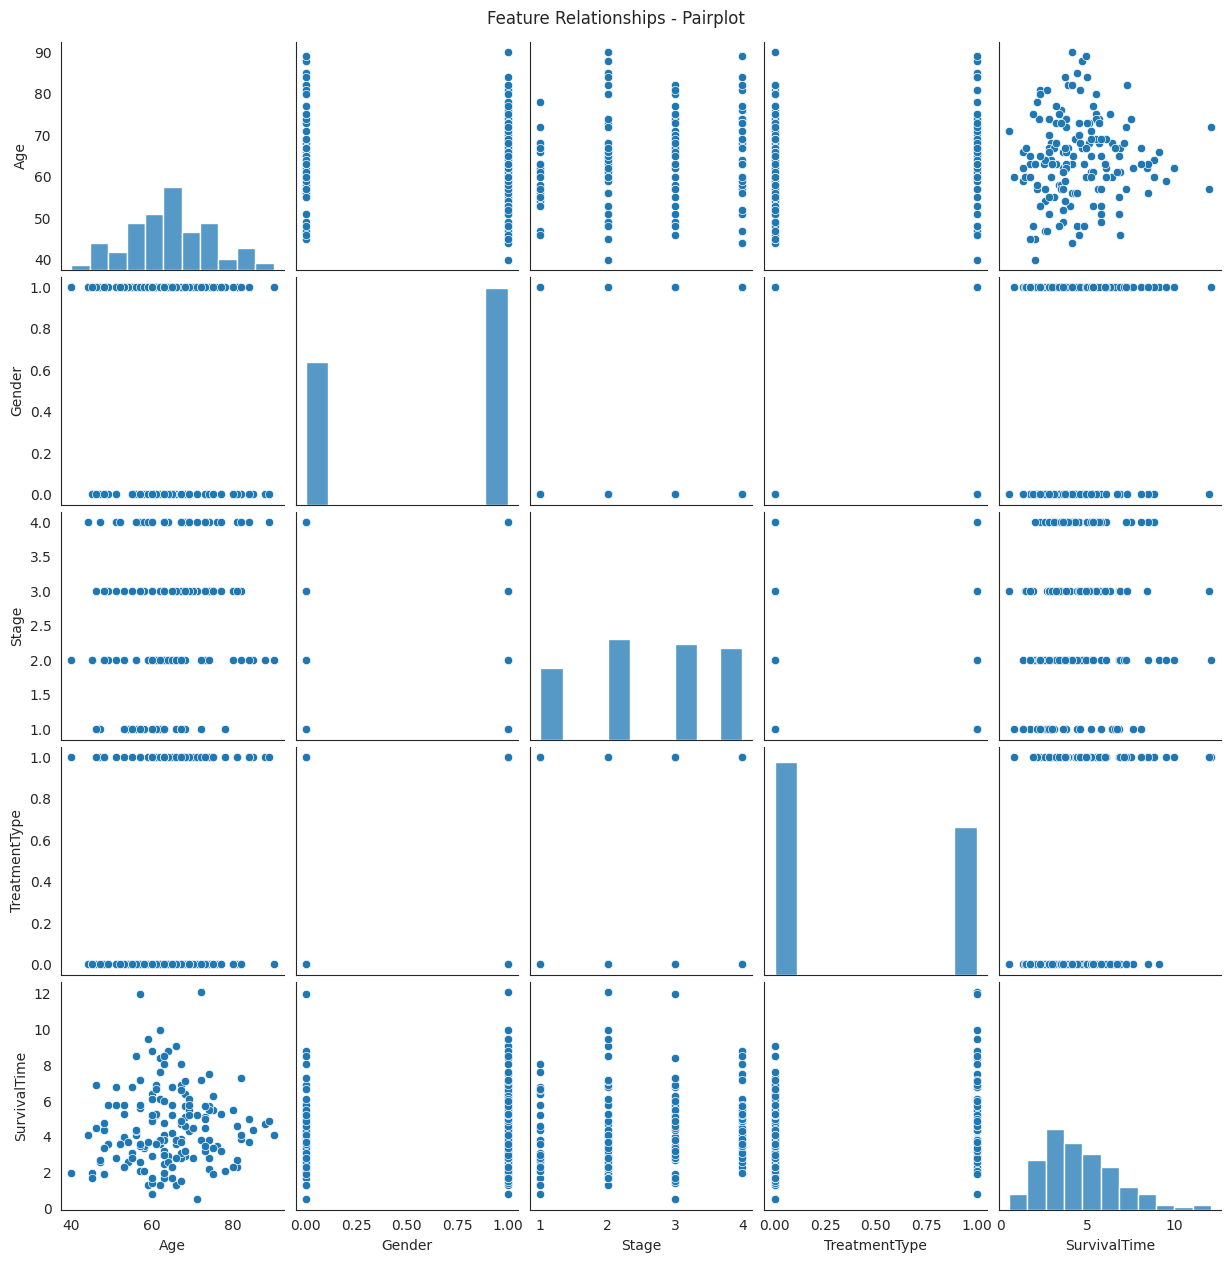

In [79]:
# Visualize feature relationships
# Note: Censored is excluded as it's a label indicator, not a predictive feature
feature_cols = ['Age', 'Gender', 'Stage', 'TreatmentType', 'SurvivalTime']
g = sns.pairplot(df_cleaned, vars=feature_cols)
g.fig.patch.set_facecolor('white')
plt.suptitle('Feature Relationships - Pairplot', y=1.01)
plt.savefig('./plots/feature_pairplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [80]:
# Define the feature matrix (X) and target vector (y)
X = df_cleaned.drop(['SurvivalTime', 'Censored','id'], axis=1)  # Drop target and censoring indicator
y = df_cleaned['SurvivalTime']  # Target variable: survival time
censored = df_cleaned['Censored']  # Censoring indicator

In [81]:
# First split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: further divide train into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

Training set size: 102 (63.4%)
Validation set size: 26 (16.1%)
Test set size: 33 (20.5%)


In [82]:
# Simple train/validation/test approach (without cross-validation)
print("=" * 60)
print("Simple Train/Validation/Test Split Approach")
print("=" * 60)

# Train model
model_simple = LinearRegression()
model_simple.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model_simple.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f'Validation MSE: {val_mse:.4f}')

# Evaluate on test set
y_test_pred = model_simple.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test MSE: {test_mse:.4f}')

# Calculate cMSE (all data points are uncensored, so c=0)
test_cmse = error_metric(y_test, y_test_pred, 0)
print(f'Test cMSE: {test_cmse:.4f}')

Simple Train/Validation/Test Split Approach
Validation MSE: 3.3672
Test MSE: 5.0473
Test cMSE: 5.0473


In [83]:
# Cross-validation approach (more robust)
print("\n" + "=" * 60)
print("Cross-Validation Approach (5-fold)")
print("=" * 60)

# Train with cross-validation
model_cv = LinearRegression()
cv_scores = cross_val_score(model_cv, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  # Convert to positive MSE

print(f"Cross-validation MSE scores: {cv_mse_scores}")
print(f"Average CV MSE: {np.mean(cv_mse_scores):.4f} (+/- {np.std(cv_mse_scores):.4f})")

# Fit model on full dataset
model_cv.fit(X, y)
y_pred_cv = model_cv.predict(X)

# Calculate metrics
train_mse = mean_squared_error(y, y_pred_cv)
train_cmse = error_metric(y, y_pred_cv, censored)
print(f"Training MSE: {train_mse:.4f}")
print(f"Training cMSE: {train_cmse:.4f}")
print("=" * 60)


Cross-Validation Approach (5-fold)
Cross-validation MSE scores: [4.20703123 2.90729383 4.5532278  3.57321375 6.09991277]
Average CV MSE: 4.2681 (+/- 1.0747)
Training MSE: 4.0873
Training cMSE: 4.0873


Comparing the Avarage MSE Cross validation value and the MSE value simple, with Cross Validation is more efficient without Cross Validation because in cross-validation, the model is trained and validated multiple times using different splits of the dataset. This means that the model gets to train on almost all of the data, which helps the model generalize better.


In [84]:
# Optional: Baseline model with pipeline (scaling + regression)
run_pipeline_test = bool(input("Run baseline model with pipeline? (y/n): ").lower() == "y")

if run_pipeline_test:
    print("\n" + "=" * 60)
    print("Pipeline Approach (Scaling + Linear Regression)")
    print("=" * 60)
    
    # Create fresh train/test split
    X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Build pipeline
    pipeline = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    
    # Train and predict
    pipeline.fit(X_train_pipe, y_train_pipe)
    y_pred_pipe = pipeline.predict(X_test_pipe)
    
    # Evaluate
    mse_pipe = mean_squared_error(y_test_pipe, y_pred_pipe)
    cmse_pipe = error_metric(y_test_pipe, y_pred_pipe, 0)
    
    print(f"Pipeline MSE: {mse_pipe:.4f}")
    print(f"Pipeline cMSE: {cmse_pipe:.4f}")
    
    # Comparison with previous approaches
    print("\n" + "=" * 60)
    print("Comparison of All Approaches")
    print("=" * 60)
    print(f"Simple Split - Test MSE:  {test_mse:.4f}")
    print(f"Simple Split - Test cMSE: {test_cmse:.4f}")
    print(f"Cross-Val    - Train MSE: {train_mse:.4f}")
    print(f"Cross-Val    - Train cMSE: {train_cmse:.4f}")
    print(f"Pipeline     - Test MSE:  {mse_pipe:.4f}")
    print(f"Pipeline     - Test cMSE: {cmse_pipe:.4f}")
    print("=" * 60)
    
    show_plots = bool(input("Visualize pipeline results? (y/n): ").lower() == "y")

    if show_plots:
        fig = plt.figure(figsize=(8, 6))
        fig.patch.set_facecolor('white')
        plt.scatter(y_test_pipe, y_pred_pipe, alpha=0.6)
        plt.plot([y_test_pipe.min(), y_test_pipe.max()], 
                 [y_test_pipe.min(), y_test_pipe.max()], 'r--', lw=2)
        plt.xlabel('True Survival Time')
        plt.ylabel('Predicted Survival Time')
        plt.title('Pipeline: True vs Predicted Survival Time')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Pipeline test skipped.")

    print("\n" + "=" * 60)
    print("Comparison of All Approaches")
    print("=" * 60)
    print(f"Simple Split - Test MSE:  {test_mse:.4f}")
    print(f"Simple Split - Test cMSE: {test_cmse:.4f}")
    print(f"Cross-Val    - Train MSE: {train_mse:.4f}")
    print(f"Cross-Val    - Train cMSE: {train_cmse:.4f}")
    print("=" * 60)


Pipeline Approach (Scaling + Linear Regression)
Pipeline MSE: 4.4112
Pipeline cMSE: 4.4112

Comparison of All Approaches
Simple Split - Test MSE:  5.0473
Simple Split - Test cMSE: 5.0473
Cross-Val    - Train MSE: 4.0873
Cross-Val    - Train cMSE: 4.0873
Pipeline     - Test MSE:  4.4112
Pipeline     - Test cMSE: 4.4112


### Task 1.2 - Learn the baseline model

Train the final baseline model using cross-validation and generate predictions for submission.


In [85]:
# Build baseline pipeline with scaling and Linear Regression
baseline_pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

# Perform 5-fold cross-validation
print("=" * 60)
print("Baseline Model Training with Cross-Validation")
print("=" * 60)

cv_scores = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores

print(f"CV MSE scores: {cv_mse_scores}")
print(f"Average CV MSE: {np.mean(cv_mse_scores):.4f} (+/- {np.std(cv_mse_scores):.4f})")

# Fit on entire training dataset
baseline_pipeline.fit(X, y)
y_pred_baseline = baseline_pipeline.predict(X)

# Evaluate final model
mse_baseline = mean_squared_error(y, y_pred_baseline)
cmse_baseline = error_metric(y, y_pred_baseline, censored)

print(f"\nFinal Model Performance:")
print(f"Training MSE:  {mse_baseline:.4f}")
print(f"Training cMSE: {cmse_baseline:.4f}")
print("=" * 60)

Baseline Model Training with Cross-Validation
CV MSE scores: [4.20703123 2.90729383 4.5532278  3.57321375 6.09991277]
Average CV MSE: 4.2681 (+/- 1.0747)

Final Model Performance:
Training MSE:  4.0873
Training cMSE: 4.0873


In [86]:
# Generate predictions for test dataset and create submission file
print("\n" + "=" * 60)
print("Generating Submission File")
print("=" * 60)

# Load test data
df_test = pd.read_csv('./data/test_data.csv')

X_test_submission = df_test.drop(['id', 'GeneticRisk', 'TreatmentResponse', 'ComorbidityIndex'], axis=1)

y_test_predictions = baseline_pipeline.predict(X_test_submission)

create_submission_file(y_test_predictions, 'baseline-submission-01.csv')

print(f"Predictions generated for {len(y_test_predictions)} test samples")
print("=" * 60)


Generating Submission File
File Created: ./results/baseline-submission-01.csv
Predictions generated for 100 test samples


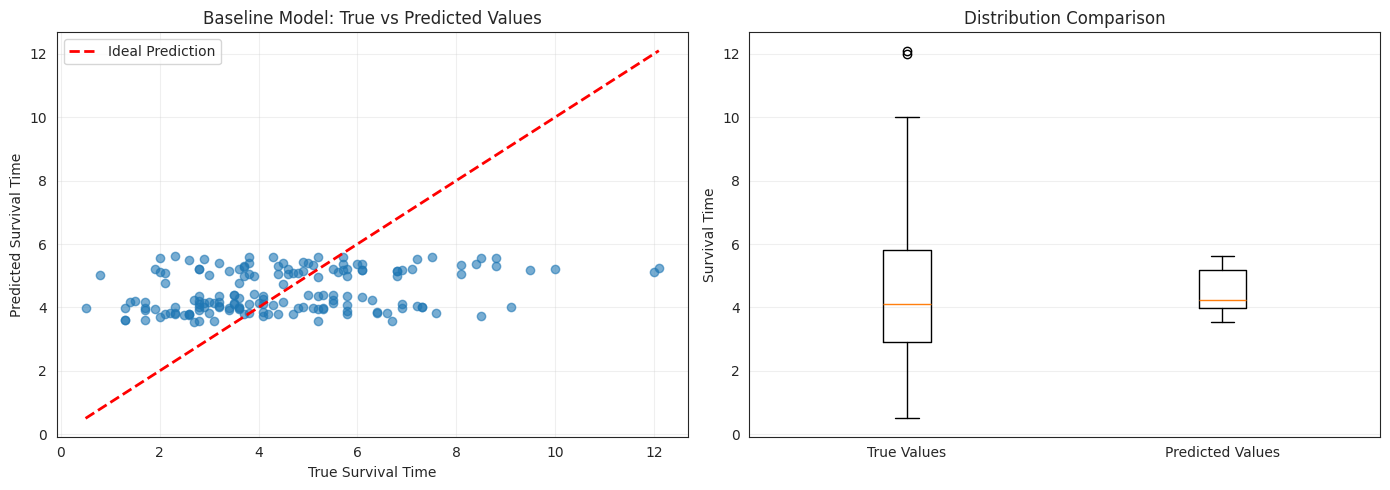

In [87]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('white')

# Scatter plot: True vs Predicted
axes[0].scatter(y, y_pred_baseline, alpha=0.6)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal Prediction')
axes[0].set_xlabel('True Survival Time')
axes[0].set_ylabel('Predicted Survival Time')
axes[0].set_title('Baseline Model: True vs Predicted Values')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot: Distribution comparison
axes[1].boxplot([y, y_pred_baseline], tick_labels=["True Values", "Predicted Values"])
axes[1].set_ylabel('Survival Time')
axes[1].set_title('Distribution Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./plots/baseline_model_performance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Save each plot separately
fig_scatter = plt.figure(figsize=(8, 6))
fig_scatter.patch.set_facecolor('white')
plt.scatter(y, y_pred_baseline, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal Prediction')
plt.xlabel('True Survival Time')
plt.ylabel('Predicted Survival Time')
plt.title('Baseline Model: True vs Predicted Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/baseline_scatter_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

fig_boxplot = plt.figure(figsize=(8, 6))
fig_boxplot.patch.set_facecolor('white')
plt.boxplot([y, y_pred_baseline], tick_labels=["True Values", "Predicted Values"])
plt.ylabel('Survival Time')
plt.title('Distribution Comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./plots/baseline_boxplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

## Task 2 - Nonlinear models

### Task 2.1 - Development


In [88]:
#polinomial regression

# Function for Polynomial Regression
def train_polynomial_regression(X, y, max_degree=15, cv=5):
    """
    Trains and evaluates Polynomial Regression with cross-validation.
    
    Args:
        X: Features
        y: Target variable
        max_degree: Maximum degree of the polynomial features
        cv: Number of cross-validation folds

    Returns:
        best_degree: The degree of the polynomial with the best cross-validation score
        best_score: The best cross-validation score
    """
    best_score = -np.inf
    best_degree = None

    # Search over a range of degrees
    for degree in range(1, max_degree + 1):
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')  # MSE scoring
        mean_score = np.mean(scores)
        
        # If this degree gives a better score, save it
        if mean_score > best_score:
            best_score = mean_score
            best_degree = degree

    print(f"Best Polynomial Degree: {best_degree}")
    print(f"Best Cross-Validation MSE: {-best_score}")
    
    # Return the best degree and corresponding score
    return best_degree, -best_score


In [89]:
# Function for k-NN Regressor
def train_knn(X, y, max_k=20, cv=5):
    """
    Trains and evaluates k-Nearest Neighbors with cross-validation.

    Args:
        X: Features
        y: Target variable
        max_k: Maximum number of neighbors to consider
        cv: Number of cross-validation folds

    Returns:
        best_k: The number of neighbors (k) with the best cross-validation score
        best_score: The best cross-validation score
    """
    best_score = -np.inf
    best_k = None

    # Search over a range of k values
    for k in range(1, max_k + 1):
        model = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')  # MSE scoring
        mean_score = np.mean(scores)
        
        # If this k gives a better score, save it
        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    print(f"Best k (Neighbors): {best_k}")
    print(f"Best Cross-Validation MSE: {-best_score}")
    
    # Return the best k and corresponding score
    return best_k, -best_score


In [90]:
# Load your training data (X, y)
# Assuming X and y are already defined and preprocessed from Task 1

# Train Polynomial Regression with Cross-validation
print("Training Polynomial Regression...")
best_degree, best_polynomial_score = train_polynomial_regression(X, y, max_degree=5, cv=5)

# Train k-NN Regressor with Cross-validation
print("\nTraining k-Nearest Neighbors...")
best_k, best_knn_score = train_knn(X, y, max_k=20, cv=5)

# You can then fit the models with the best parameters on the entire dataset
# For Polynomial Regression
best_polynomial_model = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
best_polynomial_model.fit(X, y)

# For k-NN
best_knn_model = KNeighborsRegressor(n_neighbors=best_k)
best_knn_model.fit(X, y)

# Make predictions with the best models
y_pred_polynomial = best_polynomial_model.predict(X)
y_pred_knn = best_knn_model.predict(X)

# Evaluate predictions (for example, calculating MSE)
mse_polynomial = mean_squared_error(y, y_pred_polynomial)
mse_knn = mean_squared_error(y, y_pred_knn)

print(f"Polynomial Regression MSE: {mse_polynomial}")
print(f"k-NN Regression MSE: {mse_knn}")

Training Polynomial Regression...
Best Polynomial Degree: 1
Best Cross-Validation MSE: 4.268135875846156

Training k-Nearest Neighbors...
Best k (Neighbors): 20
Best Cross-Validation MSE: 4.577803205492424
Polynomial Regression MSE: 4.087307290510991
k-NN Regression MSE: 4.220834627329192
Best k (Neighbors): 20
Best Cross-Validation MSE: 4.577803205492424
Polynomial Regression MSE: 4.087307290510991
k-NN Regression MSE: 4.220834627329192


## Task 3 - 

### Task 3.1


In [61]:

# df -> original dataframe
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

X_missingValues = df.drop(['SurvivalTime', 'Censored','id'], axis=1)  # Feature matrix with missing values  
y_missingValues = df['SurvivalTime']  # Target variable: survival time
#answering how many data points remain after dropping?
print(f"Remaining data points after dropping: {df.shape[0]}")


##neste exercicio para computar os missing values podemos sempre tratar consoante os que estão censored ou nao

id                     0
Age                    0
Gender                 0
Stage                  0
GeneticRisk           85
TreatmentType          0
ComorbidityIndex      45
TreatmentResponse     29
SurvivalTime         160
Censored               0
dtype: int64
Remaining data points after dropping: 400


In [62]:
from sklearn.impute import SimpleImputer

# Create the imputer (mean imputation)
imputer = SimpleImputer(strategy='mean')

# Apply imputer to fill missing values
X_imputed_mean = imputer.fit_transform(X_missingValues)  # X is the feature matrix

y_imputed_mean = imputer.fit_transform(y_missingValues.values.reshape(-1, 1))

# # Atualizar o y com os valores imputados
# y = y_imputed_mean.flatten()

print(y_imputed_mean)

[[ 4.2       ]
 [ 4.7       ]
 [ 3.5       ]
 [ 2.3       ]
 [ 4.47958333]
 [ 2.6       ]
 [ 4.47958333]
 [ 4.47958333]
 [ 4.47958333]
 [ 6.4       ]
 [ 4.47958333]
 [ 4.1       ]
 [ 9.1       ]
 [ 4.47958333]
 [ 3.3       ]
 [ 4.47958333]
 [ 3.        ]
 [ 4.7       ]
 [ 2.7       ]
 [ 4.47958333]
 [ 4.47958333]
 [ 1.7       ]
 [ 4.47958333]
 [ 3.6       ]
 [ 4.47958333]
 [ 4.47958333]
 [ 5.1       ]
 [ 5.3       ]
 [ 4.47958333]
 [ 4.47958333]
 [ 4.1       ]
 [ 7.5       ]
 [ 4.8       ]
 [ 1.3       ]
 [ 3.8       ]
 [ 2.        ]
 [ 6.8       ]
 [ 4.3       ]
 [ 5.2       ]
 [ 1.3       ]
 [ 4.47958333]
 [ 2.6       ]
 [ 3.3       ]
 [ 6.4       ]
 [ 4.47958333]
 [ 4.47958333]
 [ 1.9       ]
 [ 3.4       ]
 [ 4.47958333]
 [ 5.8       ]
 [ 5.6       ]
 [ 4.47958333]
 [ 2.5       ]
 [ 2.6       ]
 [ 5.8       ]
 [ 0.5       ]
 [ 4.47958333]
 [ 4.47958333]
 [ 5.2       ]
 [ 4.47958333]
 [ 4.47958333]
 [ 2.8       ]
 [ 5.2       ]
 [ 4.47958333]
 [ 1.9       ]
 [ 3.4       ]
 [ 3.9    

In [63]:
from sklearn.impute import KNNImputer

# Create the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
X_imputed_knn = knn_imputer.fit_transform(X_missingValues)  # X is the feature matrix

y_imputed_knn = knn_imputer.fit_transform(y_missingValues.values.reshape(-1, 1))


In [64]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create the iterative imputer
iterative_imputer = IterativeImputer()

# Apply iterative imputation
X_imputed_iterative = iterative_imputer.fit_transform(X_missingValues)  # X is the feature matrix

y_imputed_iterative = iterative_imputer.fit_transform(y_missingValues.values.reshape(-1, 1))

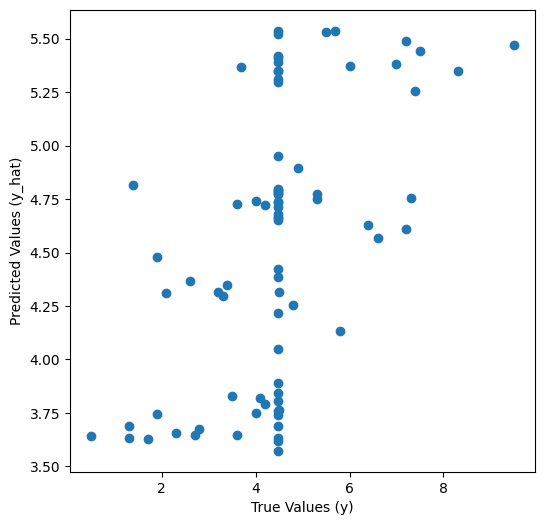

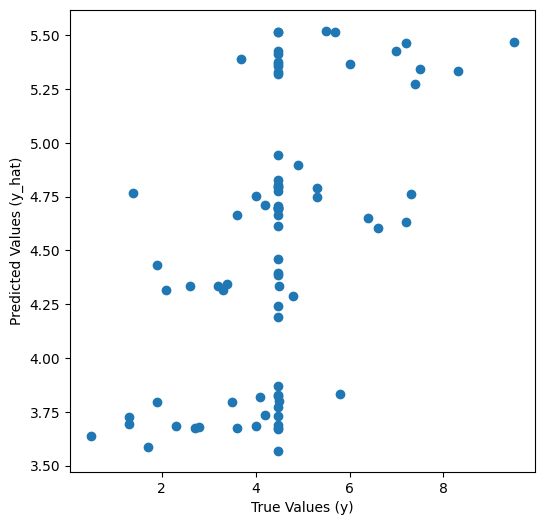

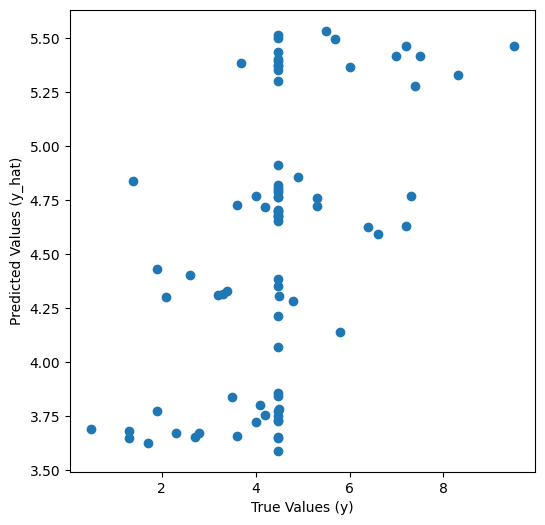

MSE com imputação por média: 1.8126934259749112
MSE com imputação por KNN: 1.8221434803431389
MSE com imputação iterativa: 1.8194736110329597


In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

model = LinearRegression()
# Função para treinar e avaliar o modelo com diferentes imputações
def evaluate_imputation(X_imputed, y):
    # Dividir os dados imputados em treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

    
    
    # Treinar o modelo
    
    model.fit(X_train, y_train)
    
    # Prever os valores
    y_pred = model.predict(X_test)
    
    # Calcular o MSE
    mse = mean_squared_error(y_test, y_pred)

   # Plotar o gráfico y vs y_hat
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values (y)')
    plt.ylabel('Predicted Values (y_hat)')
    
    plt.show()

    
    return mse

# Avaliar as três estratégias de imputação
mse_mean = evaluate_imputation(X_imputed_mean, y_imputed_mean)
mse_knn = evaluate_imputation(X_imputed_knn, y_imputed_knn)
mse_iterative = evaluate_imputation(X_imputed_iterative, y_imputed_iterative)

# Exibir os resultados
print(f'MSE com imputação por média: {mse_mean}')
print(f'MSE com imputação por KNN: {mse_knn}')
print(f'MSE com imputação iterativa: {mse_iterative}')



In [ ]:
# submission task 3.1
df_test_task3 = pd.read_csv('./data/test_data.csv')
 # quero dar drop do id
X_test_task3 = df_test_task3.drop(['id'], axis=1)

X_test_task3_imputed = imputer.fit_transform(X_test_task3)

y_test_pred1 = pipeline.predict(X_test_task3_imputed)
print(y_test_pred1)
create_submission_file(y_test_pred1.ravel(), 'baseline-submission-3.1.csv')

[[5.4007683 ]
 [3.73571725]
 [4.81597597]
 [5.44998464]
 [3.78456915]
 [5.43412458]
 [4.21555242]
 [4.30351078]
 [3.67340515]
 [3.68852536]
 [4.63382123]
 [4.70326425]
 [4.67288307]
 [4.81317666]
 [4.360838  ]
 [3.7416036 ]
 [4.7764104 ]
 [3.79323598]
 [4.3027309 ]
 [4.42571762]
 [4.84727981]
 [4.30188976]
 [5.41960346]
 [4.78618031]
 [4.85558221]
 [5.39124018]
 [4.4148184 ]
 [3.70360554]
 [3.63474173]
 [4.47177807]
 [5.38251208]
 [4.16353547]
 [3.66453739]
 [5.4460486 ]
 [5.43490446]
 [5.51862867]
 [4.30830284]
 [4.29802784]
 [4.2860627 ]
 [4.73416336]
 [4.86073823]
 [3.67099613]
 [4.98496952]
 [4.69687104]
 [5.38235227]
 [5.39606524]
 [4.66831995]
 [4.16353547]
 [4.71669514]
 [4.84803407]
 [4.89607857]
 [5.31686544]
 [4.65879183]
 [3.68039744]
 [3.61550184]
 [4.74926342]
 [5.48329979]
 [4.69174469]
 [3.69962135]
 [3.70719916]
 [5.51862867]
 [4.25170016]
 [4.44873791]
 [4.31403069]
 [3.67423317]
 [4.73334236]
 [4.70857424]
 [4.89839285]
 [3.53196127]
 [4.63184863]
 [4.61908347]
 [4.94